This is the model to discern between images with knights and non-knights.

Step 1 - Refinement of Data Preprocessing for Binary Classification

In [111]:
# Importing Libraries
import os
import shutil
import random
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [112]:
# Define Paths
dataset_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision"
input_folder_binary = "/content/gdrive/My Drive/Datasets/Chess_Vision_Binary_Knight_Input"
output_folder = "/content/gdrive/My Drive/Datasets/Chess_Vision_Binary_Knight"

In [113]:
# Function to Copy Files
def copy_files(src, dst):
    os.makedirs(dst, exist_ok=True)
    for file in os.listdir(src):
        shutil.copy(os.path.join(src, file), dst)

# Prepare Dataset
non_knight_dir = os.path.join(dataset_dir, "Non_Knight")
if not os.path.exists(non_knight_dir):
    os.makedirs(non_knight_dir)

other_pieces = ["Bishop", "Rook", "Queen", "King", "Pawn"]
num_images_per_class = 23

if len(os.listdir(non_knight_dir)) < 110:
    for piece in other_pieces:
        piece_dir = os.path.join(dataset_dir, piece)
        images = random.sample(os.listdir(piece_dir), num_images_per_class)
        for img in images:
            shutil.copy(os.path.join(piece_dir, img), os.path.join(non_knight_dir, f"{piece}_{img}"))

In [114]:
# Paths
dataset_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision"
non_knight_dir = os.path.join(dataset_dir, "Non_Knight")

# Create Non_Knight directory if it doesn't exist
if not os.path.exists(non_knight_dir):
    os.makedirs(non_knight_dir)

# Chess pieces excluding knight
other_pieces = ["Bishop", "Rook", "Queen", "King", "Pawn"]

# Number of images to copy from each class to maintain balance
num_images_per_class = 23

if len(os.listdir(non_knight_dir)) < 110:
  # Loop through each class and copy images
  for piece in other_pieces:
      piece_dir = os.path.join(dataset_dir, piece)
      images = os.listdir(piece_dir)
      selected_images = random.sample(images, num_images_per_class)

      for img in selected_images:
          src_path = os.path.join(piece_dir, img)
          dst_path = os.path.join(non_knight_dir, f"{piece}_{img}")
          shutil.copy(src_path, dst_path)

In [115]:
# Count Images
knight_count = len(os.listdir(os.path.join(dataset_dir, "Knight")))
non_knight_count = len(os.listdir(non_knight_dir))
print(f"Number of Knight images: {knight_count}")
print(f"Number of Non_Knight images: {non_knight_count}")

Number of Knight images: 106
Number of Non_Knight images: 115


In [116]:
# Base paths
raw_images_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision"
pre_images_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision_Splitted"

# Class-specific paths
knight_dir = os.path.join(raw_images_dir, "Knight")
non_knight_dir = os.path.join(raw_images_dir, "Non_Knight")


In [117]:
# Prepare Input Directory for Binary Classification
os.makedirs(input_folder_binary, exist_ok=True)
copy_files(os.path.join(dataset_dir, "Knight"), os.path.join(input_folder_binary, "Knight"))
copy_files(non_knight_dir, os.path.join(input_folder_binary, "Non_Knight"))

# Split Dataset
splitfolders.ratio(input_folder_binary, output=output_folder, seed=42, ratio=(.7, .2, .1))

Copying files: 221 files [00:04, 54.97 files/s]


In [118]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test sets

# Load images from directory and apply transformations
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)


Found 152 images belonging to 2 classes.
Found 43 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


Step 2 - Development of Binary Classification Model for Knights

In [119]:
# Load VGG16 model without the top layer
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

# Define the input layer
inputs = Input(shape=(224, 224, 3))

# Pass the image through the base model
x = base_model(inputs, training=False)

# Flatten the output of the base model
x = Flatten()(x)

# Additional layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)  # Updated dropout rate

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
binary_model = Model(inputs, outputs)

# Compile the model
binary_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Updated learning rate
                     metrics=["accuracy"])


In [120]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/Datasets/knight_detector_best_model.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.01
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)


Step 3 - Model Training and Validation

In [121]:
epochs = 10
batch_size = 32

history = binary_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[model_checkpoint, reduce_lr, early_stopping]
)


Epoch 1/10
5/5 [==============================] - 152s 31s/step - loss: 0.8190 - accuracy: 0.5263 - val_loss: 0.5810 - val_accuracy: 0.5581 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 143s 31s/step - loss: 0.5541 - accuracy: 0.7105 - val_loss: 0.2968 - val_accuracy: 0.9070 - lr: 1.0000e-04
Epoch 3/10
5/5 [==============================] - 143s 29s/step - loss: 0.3724 - accuracy: 0.8224 - val_loss: 0.2833 - val_accuracy: 0.8372 - lr: 1.0000e-04
Epoch 4/10
5/5 [==============================] - 131s 27s/step - loss: 0.2411 - accuracy: 0.9145 - val_loss: 0.1538 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/10
5/5 [==============================] - 132s 29s/step - loss: 0.1928 - accuracy: 0.9408 - val_loss: 0.1417 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/10
5/5 [==============================] - 149s 32s/step - loss: 0.1725 - accuracy: 0.9211 - val_loss: 0.0989 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/10
5/5 [==============================] - 142s 31s

Step 4 - Performance Evaluation and Model Optimization

1/1 [==============================] - 16s 16s/step - loss: 0.1207 - accuracy: 1.0000
Test Accuracy: 100.00%
1/1 [==============================] - 16s 16s/step
              precision    recall  f1-score   support

  Non_Knight       1.00      1.00      1.00        11
      Knight       1.00      1.00      1.00        12

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



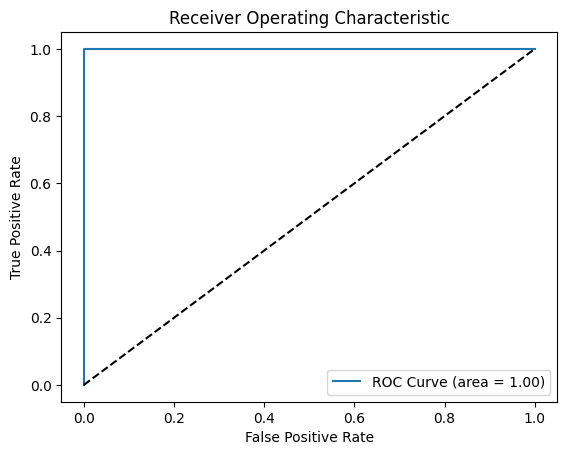

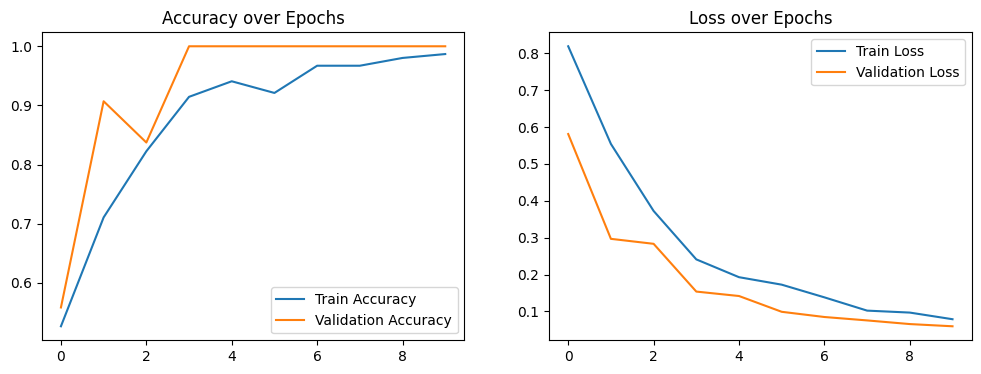

In [122]:
# Evaluate the Model
test_loss, test_accuracy = binary_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate Predictions and Evaluate
probabilities = binary_model.predict(test_generator)
predictions = [1 if x > 0.5 else 0 for x in probabilities.ravel()]
true_classes = test_generator.classes
report = classification_report(true_classes, predictions, target_names=['Non_Knight', 'Knight'])
print(report)

# ROC-AUC Score and Curve
roc_auc = roc_auc_score(true_classes, probabilities)
fpr, tpr, thresholds = roc_curve(true_classes, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()